### Environment Setup

#### Colab Specifics

In [1]:
!git clone -b shivaen-augs https://github.com/sramshetty/Balanced-Contrastive-Learning.git

Cloning into 'Balanced-Contrastive-Learning'...
remote: Enumerating objects: 290, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 290 (delta 108), reused 95 (delta 54), pack-reused 118
Receiving objects: 100% (290/290), 13.61 MiB | 13.41 MiB/s, done.
Resolving deltas: 100% (145/145), done.


In [1]:
%cd Balanced-Contrastive-Learning/

/content/Balanced-Contrastive-Learning


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#### General Setup

In [3]:
import math
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np

from tqdm import tqdm
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

from dataset.cifar import IMBALANCECIFAR10, IMBALANCECIFAR100

In [4]:
%load_ext autoreload
%autoreload 2

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
!pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load Data

CIFAR-10-LT

In [7]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))])

In [ ]:
cifar10_trainDataset = IMBALANCECIFAR10(root='/DATACENTER/3/zjg/cifar', train=True,
                                 download=True, transform=transform)
cifar10_testDataset = IMBALANCECIFAR10(root='/DATACENTER/3/zjg/cifar', train=False,
                                 download=True, transform=transform)

Files already downloaded and verified
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Files already downloaded and verified
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


In [ ]:
# Data size
print(len(cifar10_trainDataset.data))
print(len(cifar10_testDataset.data))
print(cifar10_trainDataset.get_cls_num_list())

12406
2478
[5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]


In [ ]:
cifar10_train_loader = DataLoader(cifar10_trainDataset, batch_size=64, shuffle=True, pin_memory=True)
cifar10_test_loader = DataLoader(cifar10_testDataset, batch_size=64, shuffle=False, pin_memory=True)

CIFAR-100-LT

In [8]:
cifar100_trainDataset = IMBALANCECIFAR100(root='/DATACENTER/3/zjg/cifar', train=True,
                                 download=True, transform=transform)
cifar100_testDataset = IMBALANCECIFAR100(root='/DATACENTER/3/zjg/cifar', train=False,
                                 download=True, transform=transform)

Files already downloaded and verified
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
Files already downloaded and verified
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01

In [9]:
# Data size
print(len(cifar100_trainDataset.data))
print(len(cifar100_testDataset.data))
print(cifar100_trainDataset.get_cls_num_list())

10847
2131
[500, 477, 455, 434, 415, 396, 378, 361, 344, 328, 314, 299, 286, 273, 260, 248, 237, 226, 216, 206, 197, 188, 179, 171, 163, 156, 149, 142, 135, 129, 123, 118, 112, 107, 102, 98, 93, 89, 85, 81, 77, 74, 70, 67, 64, 61, 58, 56, 53, 51, 48, 46, 44, 42, 40, 38, 36, 35, 33, 32, 30, 29, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 15, 14, 13, 13, 12, 12, 11, 11, 10, 10, 9, 9, 8, 8, 7, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5]


In [10]:
cifar100_train_loader = DataLoader(cifar100_trainDataset, batch_size=64, shuffle=True, pin_memory=True)
cifar100_test_loader = DataLoader(cifar100_testDataset, batch_size=64, shuffle=False, pin_memory=True)

## Supervised Results

In [11]:
def basic_train(model, train_loader, optimizer, criterion, n_epochs=100):
    model.to(device)
    model.train()

    accs = []
    losses = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_correct = 0
        num_preds = 0

        print(f"Epoch {epoch}")
        for data, targets in tqdm(train_loader):
            optimizer.zero_grad()

            data = data.to(device)
            targets = targets.to(device)
            batch_size = targets.size()[0]

            logits = model(data)

            loss = criterion(logits, targets)
            epoch_loss += loss.item()
            loss.backward()

            epoch_correct += torch.sum(torch.argmax(logits, dim=1) == targets).item()
            num_preds += batch_size

            optimizer.step()
        
        epoch_acc = epoch_correct / num_preds
        accs.append(epoch_acc)
        losses.append(epoch_loss)

        print(f"Loss = {epoch_loss}")
        print(f"Accuracy = {epoch_acc}")

    model.cpu()
    return accs, losses

def basic_test(model, test_loader, criterion):
    model.to(device)
    model.eval()

    preds = []
    labels = []

    with torch.no_grad():
        epoch_loss = 0
        for data, targets in tqdm(test_loader):
            data = data.to(device)
            targets =targets.to(device)

            logits = model(data)

            loss = criterion(logits, targets)
            epoch_loss += loss.item()

            preds += torch.argmax(logits, dim=1).view(-1).cpu().detach().tolist()
            labels += targets.cpu().detach().tolist()

        print("Test Loss = ", epoch_loss)

    model.cpu()
    return preds, labels

In [6]:
def compute_class_acc(cls_num_list, target, pred):
    many_classes = [i for i, num_cls in enumerate(cls_num_list) if num_cls > 100]
    medium_classes = [i for i, num_cls in enumerate(cls_num_list) if 20 <= num_cls <= 100]
    few_classes = [i for i, num_cls in enumerate(cls_num_list) if num_cls < 20]
    overall_acc=accuracy_score(target, pred)

    # Compute Accuracy for classes within each group
    many_target = []
    many_pred = []
    med_target = []
    med_pred = []
    few_target = []
    few_pred = []
    for i, j in enumerate(target):
        if j in many_classes:
            many_target.append(j)
            many_pred.append(pred[i])
        elif j in medium_classes:
            med_target.append(j)
            med_pred.append(pred[i])
        elif j in few_classes:
            few_target.append(j)
            few_pred.append(pred[i])
    
    print(f"Overall Accuracy: {overall_acc * 100}")
    print(f"Many Accuracy: {accuracy_score(many_target, many_pred) * 100}")
    print(f"Medium Accuracy: {accuracy_score(med_target, med_pred) * 100}")
    print(f"Few Accuracy: {accuracy_score(few_target, few_pred) * 100}")

    # Compute accuracy for group as a whole
    target_classes=[]
    pred_classes=[]

    for i in target:
        if i in many_classes:
            target_classes.append('1_many')
        elif i in medium_classes:
            target_classes.append('2_medium')
        else:
            target_classes.append('3_few')

    for i in pred:
        if i in many_classes:
            pred_classes.append('1_many')
        elif i in medium_classes:
            pred_classes.append('2_medium')
        else:
            pred_classes.append('3_few')

    cm_classes=confusion_matrix(target_classes, pred_classes, normalize='true')
    cm_clsses_df = pd.DataFrame(cm_classes, index =['Many','Medium','Few'], columns=['Many','Medium','Few'])
    plt.figure(figsize = (8,6))
    ax = sn.heatmap(cm_clsses_df, annot=True, cmap="Blues", vmin=0, vmax=1)
    sn.set(font_scale=2)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set(xlabel="Predicted Class", ylabel="True Class")
    plt.xlabel("Predicted Class", fontsize = 22) 
    plt.ylabel("True Class", fontsize = 22)

In [13]:
criterion = nn.CrossEntropyLoss()

### CIFAR-10-LT



#### ResNet Models

In [ ]:
from torchvision.models import resnet34, ResNet34_Weights

ResNet-34 Trained from Scratch

In [ ]:
res34_model = resnet34(weights=None, num_classes=10)
res34_opt = torch.optim.Adam(res34_model.parameters(), lr=0.03)

res34_accs, res34_losses = basic_train(res34_model, cifar10_train_loader, res34_opt, criterion, n_epochs=50)
print("-"*20)
print("Best Accuracy =", max(res34_accs))

Epoch 0


100%|██████████| 194/194 [00:21<00:00,  9.01it/s]


Loss = 379.95786213874817
Accuracy = 0.4220538449137514
Epoch 1


100%|██████████| 194/194 [00:15<00:00, 12.60it/s]


Loss = 241.77790755033493
Accuracy = 0.5667418990810899
Epoch 2


100%|██████████| 194/194 [00:21<00:00,  9.17it/s]


Loss = 210.4678544998169
Accuracy = 0.634531678220216
Epoch 3


100%|██████████| 194/194 [00:21<00:00,  9.19it/s]


Loss = 198.09631991386414
Accuracy = 0.6588747380299855
Epoch 4


100%|██████████| 194/194 [00:15<00:00, 12.54it/s]


Loss = 183.87919598817825
Accuracy = 0.6838626471062389
Epoch 5


100%|██████████| 194/194 [00:15<00:00, 12.82it/s]


Loss = 175.06013023853302
Accuracy = 0.7036111558923102
Epoch 6


100%|██████████| 194/194 [00:14<00:00, 12.95it/s]


Loss = 166.20991018414497
Accuracy = 0.7177172335966467
Epoch 7


100%|██████████| 194/194 [00:16<00:00, 11.86it/s]


Loss = 155.5924028158188
Accuracy = 0.7363372561663711
Epoch 8


100%|██████████| 194/194 [00:15<00:00, 12.82it/s]


Loss = 150.3380984067917
Accuracy = 0.7442366596807997
Epoch 9


100%|██████████| 194/194 [00:14<00:00, 12.95it/s]


Loss = 143.54273119568825
Accuracy = 0.753586974044817
Epoch 10


100%|██████████| 194/194 [00:15<00:00, 12.77it/s]


Loss = 137.04395121335983
Accuracy = 0.7634209253586974
Epoch 11


100%|██████████| 194/194 [00:15<00:00, 12.93it/s]


Loss = 137.1483187675476
Accuracy = 0.7656778977913913
Epoch 12


100%|██████████| 194/194 [00:15<00:00, 12.88it/s]


Loss = 130.66153094172478
Accuracy = 0.77688215379655
Epoch 13


100%|██████████| 194/194 [00:15<00:00, 12.22it/s]


Loss = 112.94163888692856
Accuracy = 0.8057391584717072
Epoch 14


100%|██████████| 194/194 [00:15<00:00, 12.74it/s]


Loss = 106.21660181879997
Accuracy = 0.8153312913106562
Epoch 15


100%|██████████| 194/194 [00:14<00:00, 13.00it/s]


Loss = 94.89388021826744
Accuracy = 0.8339513138803805
Epoch 16


100%|██████████| 194/194 [00:15<00:00, 12.85it/s]


Loss = 89.37675124406815
Accuracy = 0.8473319361599226
Epoch 17


100%|██████████| 194/194 [00:14<00:00, 12.96it/s]


Loss = 84.40427702665329
Accuracy = 0.8553119458326616
Epoch 18


100%|██████████| 194/194 [00:15<00:00, 12.86it/s]


Loss = 125.85465723276138
Accuracy = 0.7906658068676446
Epoch 19


100%|██████████| 194/194 [00:15<00:00, 12.90it/s]


Loss = 81.01524166762829
Accuracy = 0.8622440754473641
Epoch 20


100%|██████████| 194/194 [00:15<00:00, 12.79it/s]


Loss = 60.411866158246994
Accuracy = 0.8928744156053523
Epoch 21


100%|██████████| 194/194 [00:15<00:00, 12.92it/s]


Loss = 53.67510046809912
Accuracy = 0.9062550378848944
Epoch 22


100%|██████████| 194/194 [00:15<00:00, 12.76it/s]


Loss = 42.74298367649317
Accuracy = 0.9268096082540707
Epoch 23


100%|██████████| 194/194 [00:16<00:00, 12.12it/s]


Loss = 38.99641188234091
Accuracy = 0.9337417378687731
Epoch 24


100%|██████████| 194/194 [00:15<00:00, 12.64it/s]


Loss = 36.260004211217165
Accuracy = 0.9376914396259874
Epoch 25


100%|██████████| 194/194 [00:15<00:00, 12.87it/s]


Loss = 32.452346317470074
Accuracy = 0.9418829598581332
Epoch 26


100%|██████████| 194/194 [00:15<00:00, 12.70it/s]


Loss = 27.2470184545964
Accuracy = 0.953248428179913
Epoch 27


100%|██████████| 194/194 [00:15<00:00, 12.68it/s]


Loss = 28.49923726916313
Accuracy = 0.9506690311139772
Epoch 28


100%|██████████| 194/194 [00:15<00:00, 12.86it/s]


Loss = 21.188627868890762
Accuracy = 0.9638078349185878
Epoch 29


100%|██████████| 194/194 [00:15<00:00, 12.79it/s]


Loss = 21.19685183186084
Accuracy = 0.9642108657101403
Epoch 30


100%|██████████| 194/194 [00:15<00:00, 12.70it/s]


Loss = 21.647542661055923
Accuracy = 0.9630017733354829
Epoch 31


100%|██████████| 194/194 [00:15<00:00, 12.85it/s]


Loss = 22.639513541013002
Accuracy = 0.9626793487022408
Epoch 32


100%|██████████| 194/194 [00:15<00:00, 12.83it/s]


Loss = 36.068245224654675
Accuracy = 0.9554247944542963
Epoch 33


100%|██████████| 194/194 [00:16<00:00, 12.00it/s]


Loss = 22.597734813112766
Accuracy = 0.9625987425439304
Epoch 34


100%|██████████| 194/194 [00:15<00:00, 12.41it/s]


Loss = 12.098767505493015
Accuracy = 0.9803320973722393
Epoch 35


100%|██████████| 194/194 [00:15<00:00, 12.92it/s]


Loss = 13.158292446285486
Accuracy = 0.9784781557310979
Epoch 36


100%|██████████| 194/194 [00:15<00:00, 12.75it/s]


Loss = 14.75133163202554
Accuracy = 0.9739642108657102
Epoch 37


100%|██████████| 194/194 [00:15<00:00, 12.80it/s]


Loss = 16.796680628787726
Accuracy = 0.9713042076414639
Epoch 38


100%|██████████| 194/194 [00:15<00:00, 12.82it/s]


Loss = 18.499122763052583
Accuracy = 0.9692084475253909
Epoch 39


100%|██████████| 194/194 [00:15<00:00, 12.64it/s]


Loss = 13.915367030538619
Accuracy = 0.9769466387231984
Epoch 40


100%|██████████| 194/194 [00:15<00:00, 12.91it/s]


Loss = 12.3835076673422
Accuracy = 0.9785587618894084
Epoch 41


100%|██████████| 194/194 [00:15<00:00, 12.90it/s]


Loss = 14.947110268170945
Accuracy = 0.9748508786071256
Epoch 42


100%|██████████| 194/194 [00:15<00:00, 12.82it/s]


Loss = 8.404938524472527
Accuracy = 0.9853296791874899
Epoch 43


100%|██████████| 194/194 [00:15<00:00, 12.16it/s]


Loss = 18.193310724105686
Accuracy = 0.9704175399000483
Epoch 44


100%|██████████| 194/194 [00:15<00:00, 12.49it/s]


Loss = 8.575781945721246
Accuracy = 0.9858133161373529
Epoch 45


100%|██████████| 194/194 [00:15<00:00, 12.88it/s]


Loss = 7.557752891560085
Accuracy = 0.9862163469289054
Epoch 46


100%|██████████| 194/194 [00:15<00:00, 12.72it/s]


Loss = 11.946928347228095
Accuracy = 0.9804933096888603
Epoch 47


100%|██████████| 194/194 [00:15<00:00, 12.89it/s]


Loss = 10.852773254970089
Accuracy = 0.9823472513300016
Epoch 48


100%|██████████| 194/194 [00:15<00:00, 12.84it/s]


Loss = 11.556123617687263
Accuracy = 0.9809769466387231
Epoch 49


100%|██████████| 194/194 [00:15<00:00, 12.86it/s]


Loss = 7.112676026648842
Accuracy = 0.9880702885700468
--------------------
Best Accuracy = 0.9880702885700468


In [ ]:
res34_preds, res34_targets = basic_test(res34_model, cifar10_test_loader, criterion)

100%|██████████| 39/39 [00:01<00:00, 36.96it/s]


Test Loss =  68.36315022595227


Test Accuracy =  0.7461662631154157


Text(33.0, 0.5, 'True Class')

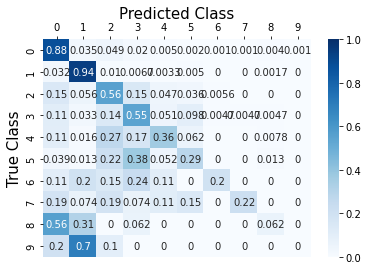

In [ ]:
print("Test Accuracy = ", accuracy_score(res34_targets, res34_preds))
bcl_res_cm = confusion_matrix(res34_targets, res34_preds, normalize='true')
bcl_res_df_cm = pd.DataFrame(bcl_res_cm, index = list(range(10)), columns=list(range(10)))
ax = sn.heatmap(bcl_res_df_cm, annot=True, cmap="Blues", vmin=0, vmax=1)
sn.set(font_scale=0.7)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set(xlabel="Predicted Class", ylabel="True Class")
plt.xlabel("Predicted Class", fontsize = 15) 
plt.ylabel("True Class", fontsize = 15)

Finetuning with ImageNet Pretrained ResNet-34

In [ ]:
pre_res34_model = resnet34(weights=ResNet34_Weights.DEFAULT)
pre_res34_model.fc = nn.Linear(512, 10)
  
pre_res34_opt = torch.optim.Adam(pre_res34_model.parameters(), lr=1e-4)

pre_res34_accs, pre_res34_losses = basic_train(pre_res34_model, cifar10_train_loader, pre_res34_opt, criterion, n_epochs=50)
print("-"*20)
print("Best Accuracy =", max(pre_res34_accs))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Epoch 0


100%|██████████| 194/194 [00:15<00:00, 12.47it/s]


Loss = 174.1166704595089
Accuracy = 0.7177978397549573
Epoch 1


100%|██████████| 194/194 [00:15<00:00, 12.85it/s]


Loss = 89.03328682482243
Accuracy = 0.8545058842495566
Epoch 2


100%|██████████| 194/194 [00:16<00:00, 11.48it/s]


Loss = 55.29711040109396
Accuracy = 0.9089956472674512
Epoch 3


100%|██████████| 194/194 [00:15<00:00, 12.59it/s]


Loss = 36.027806118130684
Accuracy = 0.9370465903595034
Epoch 4


100%|██████████| 194/194 [00:15<00:00, 12.76it/s]


Loss = 22.92725383490324
Accuracy = 0.9601805577946155
Epoch 5


100%|██████████| 194/194 [00:15<00:00, 12.87it/s]


Loss = 17.93721721600741
Accuracy = 0.9704981460583588
Epoch 6


100%|██████████| 194/194 [00:15<00:00, 12.45it/s]


Loss = 13.208300333470106
Accuracy = 0.9788005803643398
Epoch 7


100%|██████████| 194/194 [00:15<00:00, 12.65it/s]


Loss = 11.771484236698598
Accuracy = 0.9793648234725133
Epoch 8


100%|██████████| 194/194 [00:15<00:00, 12.91it/s]


Loss = 10.623219825793058
Accuracy = 0.9824278574883121
Epoch 9


100%|██████████| 194/194 [00:14<00:00, 12.97it/s]


Loss = 11.036265957634896
Accuracy = 0.9814605835885861
Epoch 10


100%|██████████| 194/194 [00:15<00:00, 12.64it/s]


Loss = 8.116156096337363
Accuracy = 0.9866193777204578
Epoch 11


100%|██████████| 194/194 [00:15<00:00, 12.79it/s]


Loss = 7.792158873053268
Accuracy = 0.9858939222956634
Epoch 12


100%|██████████| 194/194 [00:16<00:00, 12.12it/s]


Loss = 5.3292788554681465
Accuracy = 0.9906496856359825
Epoch 13


100%|██████████| 194/194 [00:15<00:00, 12.38it/s]


Loss = 4.7715470005059615
Accuracy = 0.9924230211188135
Epoch 14


100%|██████████| 194/194 [00:15<00:00, 12.61it/s]


Loss = 5.683566899620928
Accuracy = 0.9907302917942931
Epoch 15


100%|██████████| 194/194 [00:15<00:00, 12.73it/s]


Loss = 8.263189634890296
Accuracy = 0.985007254554248
Epoch 16


100%|██████████| 194/194 [00:15<00:00, 12.82it/s]


Loss = 6.561136406788137
Accuracy = 0.9901660486861196
Epoch 17


100%|██████████| 194/194 [00:15<00:00, 12.87it/s]


Loss = 5.191168038407341
Accuracy = 0.9910527164275351
Epoch 18


100%|██████████| 194/194 [00:15<00:00, 12.70it/s]


Loss = 4.752368408138864
Accuracy = 0.9919393841689506
Epoch 19


100%|██████████| 194/194 [00:15<00:00, 12.16it/s]


Loss = 5.17839806410484
Accuracy = 0.9913751410607771
Epoch 20


100%|██████████| 194/194 [00:15<00:00, 12.72it/s]


Loss = 3.5668137202155776
Accuracy = 0.9946799935515074
Epoch 21


100%|██████████| 194/194 [00:18<00:00, 10.25it/s]


Loss = 5.308226657623891
Accuracy = 0.991697565694019
Epoch 22


100%|██████████| 194/194 [00:20<00:00,  9.34it/s]


Loss = 5.4673257553367876
Accuracy = 0.9911333225858455
Epoch 23


100%|██████████| 194/194 [00:15<00:00, 12.70it/s]


Loss = 5.021826987271197
Accuracy = 0.9919393841689506
Epoch 24


100%|██████████| 194/194 [00:22<00:00,  8.61it/s]


Loss = 3.7928175701526925
Accuracy = 0.9933902950185394
Epoch 25


100%|██████████| 194/194 [00:20<00:00,  9.50it/s]


Loss = 2.951528696634341
Accuracy = 0.9954860551346123
Epoch 26


100%|██████████| 194/194 [00:15<00:00, 12.36it/s]


Loss = 2.877065398803097
Accuracy = 0.9953248428179913
Epoch 27


100%|██████████| 194/194 [00:15<00:00, 12.74it/s]


Loss = 5.521664125379175
Accuracy = 0.991536353377398
Epoch 28


100%|██████████| 194/194 [00:15<00:00, 12.60it/s]


Loss = 5.076860453584231
Accuracy = 0.991213928744156
Epoch 29


100%|██████████| 194/194 [00:15<00:00, 12.85it/s]


Loss = 3.9951456168782897
Accuracy = 0.9931484765436079
Epoch 30


100%|██████████| 194/194 [00:16<00:00, 11.52it/s]


Loss = 5.7566567385802045
Accuracy = 0.9902466548444301
Epoch 31


100%|██████████| 194/194 [00:16<00:00, 12.12it/s]


Loss = 2.732784711581189
Accuracy = 0.9961309044010962
Epoch 32


100%|██████████| 194/194 [00:16<00:00, 11.89it/s]


Loss = 2.57986485917354
Accuracy = 0.9959696920844753
Epoch 33


100%|██████████| 194/194 [00:16<00:00, 11.78it/s]


Loss = 2.406272382781026
Accuracy = 0.9958890859261648
Epoch 34


100%|██████████| 194/194 [00:15<00:00, 12.69it/s]


Loss = 3.346041192053235
Accuracy = 0.9947605997098178
Epoch 35


100%|██████████| 194/194 [00:15<00:00, 12.90it/s]


Loss = 3.332138214245788
Accuracy = 0.9937933258100919
Epoch 36


100%|██████████| 194/194 [00:15<00:00, 12.71it/s]


Loss = 3.3342632153071463
Accuracy = 0.9947605997098178
Epoch 37


100%|██████████| 194/194 [00:15<00:00, 12.84it/s]


Loss = 3.469645086894161
Accuracy = 0.9945993873931969
Epoch 38


100%|██████████| 194/194 [00:15<00:00, 12.55it/s]


Loss = 2.438573995255865
Accuracy = 0.9958890859261648
Epoch 39


100%|██████████| 194/194 [00:15<00:00, 12.77it/s]


Loss = 2.3611815671465592
Accuracy = 0.9959696920844753
Epoch 40


100%|██████████| 194/194 [00:16<00:00, 12.07it/s]


Loss = 2.950633765110979
Accuracy = 0.9954054489763018
Epoch 41


100%|██████████| 194/194 [00:15<00:00, 12.81it/s]


Loss = 1.9496656539995456
Accuracy = 0.9968563598258907
Epoch 42


100%|██████████| 194/194 [00:15<00:00, 12.74it/s]


Loss = 4.304419571795734
Accuracy = 0.993309688860229
Epoch 43


100%|██████████| 194/194 [00:15<00:00, 12.81it/s]


Loss = 2.7005123906419612
Accuracy = 0.9954054489763018
Epoch 44


100%|██████████| 194/194 [00:14<00:00, 12.97it/s]


Loss = 1.9089979474883876
Accuracy = 0.9969369659842012
Epoch 45


100%|██████████| 194/194 [00:14<00:00, 13.01it/s]


Loss = 2.6234994065089268
Accuracy = 0.9962115105594067
Epoch 46


100%|██████████| 194/194 [00:15<00:00, 12.78it/s]


Loss = 2.312963858305011
Accuracy = 0.9962921167177172
Epoch 47


100%|██████████| 194/194 [00:15<00:00, 12.87it/s]


Loss = 1.917510226056038
Accuracy = 0.9967757536675802
Epoch 48


100%|██████████| 194/194 [00:15<00:00, 12.81it/s]


Loss = 3.4935554923140444
Accuracy = 0.9945993873931969
Epoch 49


100%|██████████| 194/194 [00:15<00:00, 12.82it/s]


Loss = 1.7458060340431985
Accuracy = 0.9968563598258907
--------------------
Best Accuracy = 0.9969369659842012


In [ ]:
pre_res34_preds, pre_res34_targets = basic_test(pre_res34_model, cifar10_test_loader, criterion)

100%|██████████| 39/39 [00:01<00:00, 36.39it/s]


Test Loss =  32.69204699341208


Test Accuracy =  0.8498789346246973


Text(31.5, 0.5, 'True Class')

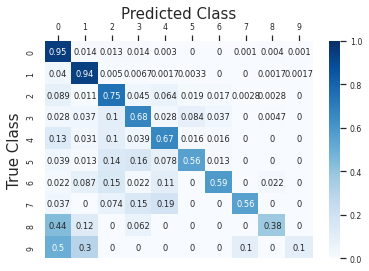

In [ ]:
print("Test Accuracy = ", accuracy_score(pre_res34_targets, pre_res34_preds))
bcl_res_cm = confusion_matrix(pre_res34_targets, pre_res34_preds, normalize='true')
bcl_res_df_cm = pd.DataFrame(bcl_res_cm, index = list(range(10)), columns=list(range(10)))
ax = sn.heatmap(bcl_res_df_cm, annot=True, cmap="Blues", vmin=0, vmax=1)
sn.set(font_scale=0.7)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set(xlabel="Predicted Class", ylabel="True Class")
plt.xlabel("Predicted Class", fontsize = 15) 
plt.ylabel("True Class", fontsize = 15)

#### Vision Transformer

From Scratch

In [ ]:
from vit_pytorch import ViT

vit_model = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 256,
    depth = 3,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)

vit_opt = torch.optim.Adam(vit_model.parameters(), lr=0.07)

vit_accs, vit_losses = basic_train(vit_model, cifar10_train_loader, vit_opt, criterion, n_epochs=50)
print("Best Accuracy =", max(vit_accs))

Epoch 0


100%|██████████| 194/194 [00:11<00:00, 17.45it/s]


Loss = 477.29030072689056
Accuracy = 0.3605513461228438
Epoch 1


100%|██████████| 194/194 [00:10<00:00, 18.89it/s]


Loss = 322.3506683111191
Accuracy = 0.39875866516201836
Epoch 2


100%|██████████| 194/194 [00:10<00:00, 19.25it/s]


Loss = 321.82830107212067
Accuracy = 0.39480896340480415
Epoch 3


100%|██████████| 194/194 [00:10<00:00, 19.03it/s]


Loss = 310.3982471227646
Accuracy = 0.40367564081895857
Epoch 4


100%|██████████| 194/194 [00:10<00:00, 19.06it/s]


Loss = 302.84086668491364
Accuracy = 0.41359019829114946
Epoch 5


100%|██████████| 194/194 [00:10<00:00, 19.16it/s]


Loss = 308.53306472301483
Accuracy = 0.40440109624375303
Epoch 6


100%|██████████| 194/194 [00:10<00:00, 19.25it/s]


Loss = 304.35404348373413
Accuracy = 0.4268902144123811
Epoch 7


100%|██████████| 194/194 [00:10<00:00, 19.28it/s]


Loss = 299.57109892368317
Accuracy = 0.42616475898758666
Epoch 8


100%|██████████| 194/194 [00:10<00:00, 19.38it/s]


Loss = 305.62424862384796
Accuracy = 0.4195550540061261
Epoch 9


100%|██████████| 194/194 [00:10<00:00, 19.02it/s]


Loss = 301.2558845281601
Accuracy = 0.41673383846525874
Epoch 10


100%|██████████| 194/194 [00:10<00:00, 19.25it/s]


Loss = 299.5034215450287
Accuracy = 0.4273738513622441
Epoch 11


100%|██████████| 194/194 [00:10<00:00, 19.04it/s]


Loss = 302.78009259700775
Accuracy = 0.4221344510720619
Epoch 12


100%|██████████| 194/194 [00:10<00:00, 19.09it/s]


Loss = 309.08859169483185
Accuracy = 0.4139126229243914
Epoch 13


100%|██████████| 194/194 [00:10<00:00, 19.03it/s]


Loss = 304.7568949460983
Accuracy = 0.4175399000483637
Epoch 14


100%|██████████| 194/194 [00:10<00:00, 17.97it/s]


Loss = 307.1476572751999
Accuracy = 0.4152829276156698
Epoch 15


100%|██████████| 194/194 [00:10<00:00, 18.96it/s]


Loss = 302.41633570194244
Accuracy = 0.4254393035627922
Epoch 16


100%|██████████| 194/194 [00:10<00:00, 18.79it/s]


Loss = 302.19181191921234
Accuracy = 0.4222956633886829
Epoch 17


100%|██████████| 194/194 [00:10<00:00, 19.13it/s]


Loss = 307.05293583869934
Accuracy = 0.41834596163146864
Epoch 18


100%|██████████| 194/194 [00:10<00:00, 19.03it/s]


Loss = 296.8634134531021
Accuracy = 0.43744962115105596
Epoch 19


100%|██████████| 194/194 [00:10<00:00, 19.08it/s]


Loss = 297.67665779590607
Accuracy = 0.4321296147025633
Epoch 20


100%|██████████| 194/194 [00:10<00:00, 18.95it/s]


Loss = 304.0734875202179
Accuracy = 0.41995808479767854
Epoch 21


100%|██████████| 194/194 [00:10<00:00, 18.96it/s]


Loss = 299.9369486570358
Accuracy = 0.4239077865548928
Epoch 22


100%|██████████| 194/194 [00:10<00:00, 19.20it/s]


Loss = 298.67478704452515
Accuracy = 0.43575689182653554
Epoch 23


100%|██████████| 194/194 [00:10<00:00, 19.12it/s]


Loss = 301.3793377876282
Accuracy = 0.4272932452039336
Epoch 24


100%|██████████| 194/194 [00:10<00:00, 19.00it/s]


Loss = 293.439009308815
Accuracy = 0.4394647751088183
Epoch 25


100%|██████████| 194/194 [00:10<00:00, 19.18it/s]


Loss = 297.56884503364563
Accuracy = 0.4334193132355312
Epoch 26


100%|██████████| 194/194 [00:10<00:00, 19.10it/s]


Loss = 295.4347769021988
Accuracy = 0.43092052232790584
Epoch 27


100%|██████████| 194/194 [00:10<00:00, 19.08it/s]


Loss = 313.102187871933
Accuracy = 0.4077059487344833
Epoch 28


100%|██████████| 194/194 [00:10<00:00, 19.05it/s]


Loss = 311.1447938680649
Accuracy = 0.41479929066580684
Epoch 29


100%|██████████| 194/194 [00:11<00:00, 17.50it/s]


Loss = 312.15422344207764
Accuracy = 0.41028534580041914
Epoch 30


100%|██████████| 194/194 [00:10<00:00, 18.68it/s]


Loss = 302.0782289505005
Accuracy = 0.42640657746251814
Epoch 31


100%|██████████| 194/194 [00:10<00:00, 19.03it/s]


Loss = 297.3989951610565
Accuracy = 0.43390295018539415
Epoch 32


100%|██████████| 194/194 [00:10<00:00, 18.99it/s]


Loss = 297.43945944309235
Accuracy = 0.43229082701918425
Epoch 33


100%|██████████| 194/194 [00:10<00:00, 19.06it/s]


Loss = 296.03881645202637
Accuracy = 0.4367241657262615
Epoch 34


100%|██████████| 194/194 [00:10<00:00, 19.01it/s]


Loss = 297.4138023853302
Accuracy = 0.4383362888924714
Epoch 35


100%|██████████| 194/194 [00:10<00:00, 18.81it/s]


Loss = 296.4551351070404
Accuracy = 0.4346284056101886
Epoch 36


100%|██████████| 194/194 [00:10<00:00, 19.02it/s]


Loss = 297.48506593704224
Accuracy = 0.43688537804288247
Epoch 37


100%|██████████| 194/194 [00:10<00:00, 18.90it/s]


Loss = 300.07732105255127
Accuracy = 0.44035144285023375
Epoch 38


100%|██████████| 194/194 [00:10<00:00, 18.79it/s]


Loss = 292.6465938091278
Accuracy = 0.44865387715621474
Epoch 39


100%|██████████| 194/194 [00:10<00:00, 19.06it/s]


Loss = 295.3847851753235
Accuracy = 0.44704175399000484
Epoch 40


100%|██████████| 194/194 [00:10<00:00, 19.08it/s]


Loss = 301.7549397945404
Accuracy = 0.4472029663066258
Epoch 41


100%|██████████| 194/194 [00:10<00:00, 18.91it/s]


Loss = 297.6564676761627
Accuracy = 0.43873931968402385
Epoch 42


100%|██████████| 194/194 [00:10<00:00, 19.01it/s]


Loss = 296.94615292549133
Accuracy = 0.4348702240851201
Epoch 43


100%|██████████| 194/194 [00:10<00:00, 17.76it/s]


Loss = 291.38080871105194
Accuracy = 0.4576011607286797
Epoch 44


100%|██████████| 194/194 [00:10<00:00, 18.90it/s]


Loss = 289.5913041830063
Accuracy = 0.4589714654199581
Epoch 45


100%|██████████| 194/194 [00:10<00:00, 18.71it/s]


Loss = 289.9655839204788
Accuracy = 0.45832661615347414
Epoch 46


100%|██████████| 194/194 [00:10<00:00, 19.04it/s]


Loss = 292.12589144706726
Accuracy = 0.4528453973883605
Epoch 47


100%|██████████| 194/194 [00:10<00:00, 18.54it/s]


Loss = 291.7653123140335
Accuracy = 0.4520393358052555
Epoch 48


100%|██████████| 194/194 [00:10<00:00, 19.00it/s]


Loss = 300.7317740917206
Accuracy = 0.4430920522327906
Epoch 49


100%|██████████| 194/194 [00:10<00:00, 19.01it/s]

Loss = 292.2298091650009
Accuracy = 0.45155569885539254
Best Accuracy = 0.4589714654199581


In [ ]:
vit_preds, vit_targets = basic_test(vit_model, cifar10_test_loader, criterion)

100%|██████████| 39/39 [00:00<00:00, 41.40it/s]

Test Loss =  58.21055030822754


Test Accuracy =  0.45036319612590797


Text(31.5, 0.5, 'True Class')

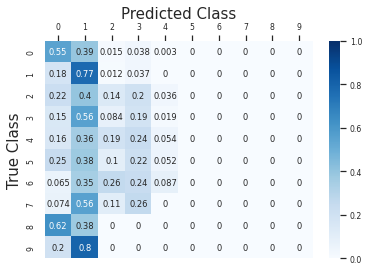

In [ ]:
print("Test Accuracy = ", accuracy_score(vit_targets, vit_preds))
bcl_res_cm = confusion_matrix(vit_targets, vit_preds, normalize='true')
bcl_res_df_cm = pd.DataFrame(bcl_res_cm, index = list(range(10)), columns=list(range(10)))
ax = sn.heatmap(bcl_res_df_cm, annot=True, cmap="Blues", vmin=0, vmax=1)
sn.set(font_scale=0.7)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set(xlabel="Predicted Class", ylabel="True Class")
plt.xlabel("Predicted Class", fontsize = 15) 
plt.ylabel("True Class", fontsize = 15)

Visualize Training of CIFAR-10

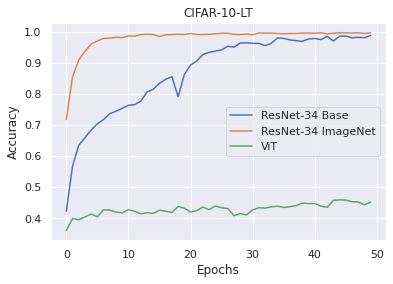

In [ ]:
x = list(range(50)) # Number of epochs to plot

plt.plot(x, res34_accs, label = "ResNet-34 Base")
plt.plot(x, pre_res34_accs, label = "ResNet-34 ImageNet")
plt.plot(x, vit_accs, label = "ViT")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CIFAR-10-LT")
plt.legend()
plt.show()

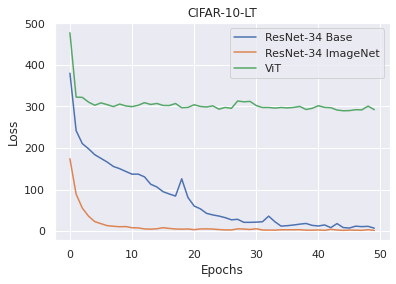

In [ ]:
plt.plot(x, res34_losses, label = "ResNet-34 Base")
plt.plot(x, pre_res34_losses, label = "ResNet-34 ImageNet")
plt.plot(x, vit_losses, label = "ViT")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CIFAR-10-LT")
plt.legend()
plt.show()

### CIFAR-100-LT

#### ResNet Models

In [14]:
from torchvision.models import resnet34, ResNet34_Weights

ResNet-34 Trained from Scratch

In [15]:
res34_model100 = resnet34(weights=None, num_classes=100)
res34_opt100 = torch.optim.Adam(res34_model100.parameters(), lr=0.01)

res34_accs100, res34_losses100 = basic_train(res34_model100, cifar100_train_loader, res34_opt100, criterion, n_epochs=50)
print("-"*20)
print("Best Accuracy =", max(res34_accs100))

Epoch 0


100%|██████████| 170/170 [00:16<00:00, 10.35it/s]


Loss = 766.241687297821
Accuracy = 0.05218032635751821
Epoch 1


100%|██████████| 170/170 [00:13<00:00, 12.58it/s]


Loss = 653.6200313568115
Accuracy = 0.09209919793491288
Epoch 2


100%|██████████| 170/170 [00:13<00:00, 12.59it/s]


Loss = 605.0648128986359
Accuracy = 0.14363418456716143
Epoch 3


100%|██████████| 170/170 [00:14<00:00, 11.75it/s]


Loss = 576.3497595787048
Accuracy = 0.17866691251037153
Epoch 4


100%|██████████| 170/170 [00:13<00:00, 12.65it/s]


Loss = 556.2169115543365
Accuracy = 0.2054024154144003
Epoch 5


100%|██████████| 170/170 [00:13<00:00, 12.53it/s]


Loss = 531.7497406005859
Accuracy = 0.2312160044251867
Epoch 6


100%|██████████| 170/170 [00:13<00:00, 12.75it/s]


Loss = 515.5281391143799
Accuracy = 0.2533419378630036
Epoch 7


100%|██████████| 170/170 [00:13<00:00, 12.51it/s]


Loss = 500.4543709754944
Accuracy = 0.2692910482160966
Epoch 8


100%|██████████| 170/170 [00:13<00:00, 12.73it/s]


Loss = 479.63651847839355
Accuracy = 0.295104637226883
Epoch 9


100%|██████████| 170/170 [00:13<00:00, 12.61it/s]


Loss = 453.0458173751831
Accuracy = 0.3317968101779294
Epoch 10


100%|██████████| 170/170 [00:13<00:00, 12.63it/s]


Loss = 430.95818305015564
Accuracy = 0.350696044989398
Epoch 11


100%|██████████| 170/170 [00:13<00:00, 12.51it/s]


Loss = 401.6656051874161
Accuracy = 0.38831013183368673
Epoch 12


100%|██████████| 170/170 [00:13<00:00, 12.69it/s]


Loss = 376.8099913597107
Accuracy = 0.41818014197473957
Epoch 13


100%|██████████| 170/170 [00:14<00:00, 12.12it/s]


Loss = 355.5860517024994
Accuracy = 0.44712823822255
Epoch 14


100%|██████████| 170/170 [00:13<00:00, 12.67it/s]


Loss = 317.0971345901489
Accuracy = 0.5012445837558772
Epoch 15


100%|██████████| 170/170 [00:13<00:00, 12.76it/s]


Loss = 286.16855704784393
Accuracy = 0.5408868811652991
Epoch 16


100%|██████████| 170/170 [00:13<00:00, 12.55it/s]


Loss = 252.7638634443283
Accuracy = 0.5849543652622845
Epoch 17


100%|██████████| 170/170 [00:13<00:00, 12.57it/s]


Loss = 249.04777377843857
Accuracy = 0.5916843366829538
Epoch 18


100%|██████████| 170/170 [00:13<00:00, 12.57it/s]


Loss = 210.82046604156494
Accuracy = 0.650502443071817
Epoch 19


100%|██████████| 170/170 [00:13<00:00, 12.58it/s]


Loss = 180.6479212641716
Accuracy = 0.6930948649396146
Epoch 20


100%|██████████| 170/170 [00:13<00:00, 12.50it/s]


Loss = 180.070714533329
Accuracy = 0.692449525214345
Epoch 21


100%|██████████| 170/170 [00:13<00:00, 12.63it/s]


Loss = 140.65962064266205
Accuracy = 0.7588273255277957
Epoch 22


100%|██████████| 170/170 [00:13<00:00, 12.56it/s]


Loss = 112.64850729703903
Accuracy = 0.8017885129528902
Epoch 23


100%|██████████| 170/170 [00:13<00:00, 12.47it/s]


Loss = 85.37069116532803
Accuracy = 0.8496358440121693
Epoch 24


100%|██████████| 170/170 [00:13<00:00, 12.68it/s]


Loss = 74.98058921098709
Accuracy = 0.865861528533235
Epoch 25


100%|██████████| 170/170 [00:13<00:00, 12.67it/s]


Loss = 83.8427839577198
Accuracy = 0.8527703512491933
Epoch 26


100%|██████████| 170/170 [00:13<00:00, 12.68it/s]


Loss = 126.40158596634865
Accuracy = 0.7871300820503365
Epoch 27


100%|██████████| 170/170 [00:14<00:00, 12.05it/s]


Loss = 77.34107266366482
Accuracy = 0.8644786576933714
Epoch 28


100%|██████████| 170/170 [00:13<00:00, 12.64it/s]


Loss = 76.82808569073677
Accuracy = 0.8606988107310777
Epoch 29


100%|██████████| 170/170 [00:13<00:00, 12.53it/s]


Loss = 84.02289219200611
Accuracy = 0.8547985618143266
Epoch 30


100%|██████████| 170/170 [00:13<00:00, 12.71it/s]


Loss = 46.20702687650919
Accuracy = 0.9167511754402139
Epoch 31


100%|██████████| 170/170 [00:13<00:00, 12.63it/s]


Loss = 24.594226462766528
Accuracy = 0.9518760947727483
Epoch 32


100%|██████████| 170/170 [00:13<00:00, 12.45it/s]


Loss = 18.930954840034246
Accuracy = 0.9657048031713837
Epoch 33


100%|██████████| 170/170 [00:13<00:00, 12.65it/s]


Loss = 19.607859982177615
Accuracy = 0.9655204203927353
Epoch 34


100%|██████████| 170/170 [00:13<00:00, 12.54it/s]


Loss = 24.64785797894001
Accuracy = 0.9515073292154512
Epoch 35


100%|██████████| 170/170 [00:13<00:00, 12.61it/s]


Loss = 32.34718806669116
Accuracy = 0.9377708122061399
Epoch 36


100%|██████████| 170/170 [00:13<00:00, 12.53it/s]


Loss = 34.55787876062095
Accuracy = 0.9344519221904675
Epoch 37


100%|██████████| 170/170 [00:13<00:00, 12.60it/s]


Loss = 29.149960156530142
Accuracy = 0.9449617405734304
Epoch 38


100%|██████████| 170/170 [00:13<00:00, 12.57it/s]


Loss = 24.11292675882578
Accuracy = 0.9562090900709874
Epoch 39


100%|██████████| 170/170 [00:13<00:00, 12.60it/s]


Loss = 23.98481029458344
Accuracy = 0.9544574536738268
Epoch 40


100%|██████████| 170/170 [00:14<00:00, 11.88it/s]


Loss = 24.859522280283272
Accuracy = 0.955655941735042
Epoch 41


100%|██████████| 170/170 [00:13<00:00, 12.48it/s]


Loss = 23.76953712757677
Accuracy = 0.955287176177745
Epoch 42


100%|██████████| 170/170 [00:13<00:00, 12.69it/s]


Loss = 29.97244519740343
Accuracy = 0.9424725730616761
Epoch 43


100%|██████████| 170/170 [00:13<00:00, 12.56it/s]


Loss = 31.245012199506164
Accuracy = 0.9425647644510002
Epoch 44


100%|██████████| 170/170 [00:13<00:00, 12.61it/s]


Loss = 25.15249592065811
Accuracy = 0.9527058172766664
Epoch 45


100%|██████████| 170/170 [00:13<00:00, 12.67it/s]


Loss = 24.871399479918182
Accuracy = 0.9544574536738268
Epoch 46


100%|██████████| 170/170 [00:13<00:00, 12.51it/s]


Loss = 20.15305716264993
Accuracy = 0.9625702959343597
Epoch 47


100%|██████████| 170/170 [00:13<00:00, 12.43it/s]


Loss = 15.623398458585143
Accuracy = 0.9704065640269199
Epoch 48


100%|██████████| 170/170 [00:13<00:00, 12.63it/s]


Loss = 18.85205198917538
Accuracy = 0.9667189084539504
Epoch 49


100%|██████████| 170/170 [00:13<00:00, 12.64it/s]


Loss = 25.906704092398286
Accuracy = 0.953719922559233
--------------------
Best Accuracy = 0.9704065640269199


In [16]:
res34_preds100, res34_targets100 = basic_test(res34_model100, cifar100_test_loader, criterion)

100%|██████████| 34/34 [00:00<00:00, 35.52it/s]


Test Loss =  238.9203758239746


Overall Accuracy: 36.97794462693571
Many Accuracy: 43.08571428571429
Medium Accuracy: 9.393939393939393
Few Accuracy: 5.88235294117647


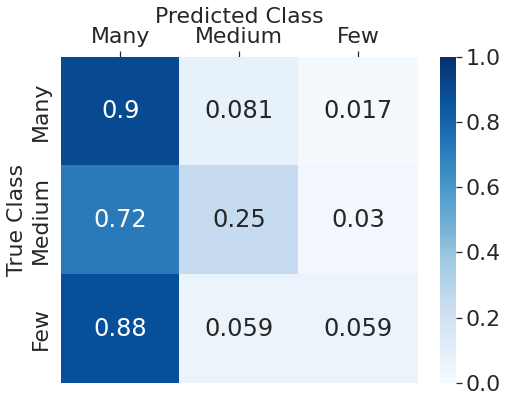

In [26]:
compute_class_acc(cifar100_trainDataset.get_cls_num_list(), res34_targets100, res34_preds100)

Finetuning with ImageNet Pretrained ResNet-34

In [18]:
pre_res34_model100 = resnet34(weights=ResNet34_Weights.DEFAULT)
pre_res34_model100.fc = nn.Linear(512, 100)
  
pre_res34_opt100 = torch.optim.Adam(pre_res34_model100.parameters(), lr=1e-4)

pre_res34_accs100, pre_res34_losses100 = basic_train(pre_res34_model100, cifar100_train_loader, pre_res34_opt100, criterion, n_epochs=50)
print("-"*20)
print("Best Accuracy =", max(pre_res34_accs100))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Epoch 0


100%|██████████| 170/170 [00:13<00:00, 12.28it/s]


Loss = 538.8962304592133
Accuracy = 0.2809071632709505
Epoch 1


100%|██████████| 170/170 [00:13<00:00, 12.60it/s]


Loss = 321.5993846654892
Accuracy = 0.5231861344150457
Epoch 2


100%|██████████| 170/170 [00:13<00:00, 12.27it/s]


Loss = 219.33394700288773
Accuracy = 0.6619341753480225
Epoch 3


100%|██████████| 170/170 [00:13<00:00, 12.32it/s]


Loss = 151.12589710950851
Accuracy = 0.7675855075135982
Epoch 4


100%|██████████| 170/170 [00:13<00:00, 12.65it/s]


Loss = 102.05158966779709
Accuracy = 0.8429980639808242
Epoch 5


100%|██████████| 170/170 [00:13<00:00, 12.74it/s]


Loss = 65.13018347322941
Accuracy = 0.9038443809348207
Epoch 6


100%|██████████| 170/170 [00:13<00:00, 12.58it/s]


Loss = 45.39491621404886
Accuracy = 0.9341753480224947
Epoch 7


100%|██████████| 170/170 [00:13<00:00, 12.58it/s]


Loss = 32.64826840907335
Accuracy = 0.9567622384069328
Epoch 8


100%|██████████| 170/170 [00:13<00:00, 12.59it/s]


Loss = 24.04136061668396
Accuracy = 0.9667189084539504
Epoch 9


100%|██████████| 170/170 [00:13<00:00, 12.42it/s]


Loss = 18.705554246902466
Accuracy = 0.975108324882456
Epoch 10


100%|██████████| 170/170 [00:13<00:00, 12.57it/s]


Loss = 19.375765793025494
Accuracy = 0.9724347745920531
Epoch 11


100%|██████████| 170/170 [00:13<00:00, 12.67it/s]


Loss = 17.627487299963832
Accuracy = 0.975108324882456
Epoch 12


100%|██████████| 170/170 [00:13<00:00, 12.70it/s]


Loss = 19.133642783388495
Accuracy = 0.9701299898589472
Epoch 13


100%|██████████| 170/170 [00:13<00:00, 12.56it/s]


Loss = 22.4134613070637
Accuracy = 0.9643219323315202
Epoch 14


100%|██████████| 170/170 [00:13<00:00, 12.51it/s]


Loss = 19.608133606612682
Accuracy = 0.9693924587443533
Epoch 15


100%|██████████| 170/170 [00:13<00:00, 12.28it/s]


Loss = 15.787492929957807
Accuracy = 0.9734488798746197
Epoch 16


100%|██████████| 170/170 [00:13<00:00, 12.27it/s]


Loss = 15.307980984449387
Accuracy = 0.9729879229279985
Epoch 17


100%|██████████| 170/170 [00:13<00:00, 12.61it/s]


Loss = 12.107532961294055
Accuracy = 0.9817461049138011
Epoch 18


100%|██████████| 170/170 [00:13<00:00, 12.50it/s]


Loss = 11.489851680584252
Accuracy = 0.9817461049138011
Epoch 19


100%|██████████| 170/170 [00:13<00:00, 12.38it/s]


Loss = 11.007252718321979
Accuracy = 0.9822992532497464
Epoch 20


100%|██████████| 170/170 [00:13<00:00, 12.55it/s]


Loss = 8.250829780008644
Accuracy = 0.9870932054946068
Epoch 21


100%|██████████| 170/170 [00:13<00:00, 12.52it/s]


Loss = 10.8091065492481
Accuracy = 0.9815617221351526
Epoch 22


100%|██████████| 170/170 [00:13<00:00, 12.57it/s]


Loss = 11.681318778544664
Accuracy = 0.9803632340739374
Epoch 23


100%|██████████| 170/170 [00:13<00:00, 12.59it/s]


Loss = 9.588223417289555
Accuracy = 0.9851571863187978
Epoch 24


100%|██████████| 170/170 [00:13<00:00, 12.52it/s]


Loss = 9.446260722354054
Accuracy = 0.9837743154789342
Epoch 25


100%|██████████| 170/170 [00:13<00:00, 12.55it/s]


Loss = 12.608719600364566
Accuracy = 0.9775974923942103
Epoch 26


100%|██████████| 170/170 [00:13<00:00, 12.61it/s]


Loss = 10.45995989954099
Accuracy = 0.9825758274177192
Epoch 27


100%|██████████| 170/170 [00:13<00:00, 12.48it/s]


Loss = 13.377922513056546
Accuracy = 0.9773209182262377
Epoch 28


100%|██████████| 170/170 [00:13<00:00, 12.42it/s]


Loss = 13.18661866383627
Accuracy = 0.9799944685166405
Epoch 29


100%|██████████| 170/170 [00:14<00:00, 12.11it/s]


Loss = 8.480404896195978
Accuracy = 0.985249377708122
Epoch 30


100%|██████████| 170/170 [00:13<00:00, 12.44it/s]


Loss = 8.648407737025991
Accuracy = 0.9860791002120401
Epoch 31


100%|██████████| 170/170 [00:13<00:00, 12.51it/s]


Loss = 9.30835920246318
Accuracy = 0.9850649949294736
Epoch 32


100%|██████████| 170/170 [00:13<00:00, 12.48it/s]


Loss = 7.3530956821050495
Accuracy = 0.9876463538305522
Epoch 33


100%|██████████| 170/170 [00:13<00:00, 12.58it/s]


Loss = 7.977603315608576
Accuracy = 0.9873697796625795
Epoch 34


100%|██████████| 170/170 [00:13<00:00, 12.57it/s]


Loss = 5.693083974707406
Accuracy = 0.9904120955102793
Epoch 35


100%|██████████| 170/170 [00:13<00:00, 12.54it/s]


Loss = 8.168989012250677
Accuracy = 0.9858947174333917
Epoch 36


100%|██████████| 170/170 [00:13<00:00, 12.39it/s]


Loss = 7.836291193496436
Accuracy = 0.9858025260440675
Epoch 37


100%|██████████| 170/170 [00:13<00:00, 12.56it/s]


Loss = 9.503162879729643
Accuracy = 0.9832211671429888
Epoch 38


100%|██████████| 170/170 [00:13<00:00, 12.48it/s]


Loss = 12.178481000941247
Accuracy = 0.9796257029593436
Epoch 39


100%|██████████| 170/170 [00:13<00:00, 12.60it/s]


Loss = 10.238984138006344
Accuracy = 0.9820226790817738
Epoch 40


100%|██████████| 170/170 [00:13<00:00, 12.61it/s]


Loss = 7.341216524888296
Accuracy = 0.9873697796625795
Epoch 41


100%|██████████| 170/170 [00:14<00:00, 12.09it/s]


Loss = 6.4880551979877055
Accuracy = 0.9898589471743339
Epoch 42


100%|██████████| 170/170 [00:13<00:00, 12.36it/s]


Loss = 6.299463714589365
Accuracy = 0.9901355213423066
Epoch 43


100%|██████████| 170/170 [00:13<00:00, 12.56it/s]


Loss = 6.404914453043602
Accuracy = 0.9905042868996036
Epoch 44


100%|██████████| 170/170 [00:13<00:00, 12.59it/s]


Loss = 5.589317523757927
Accuracy = 0.9905042868996036
Epoch 45


100%|██████████| 170/170 [00:13<00:00, 12.49it/s]


Loss = 6.964365060674027
Accuracy = 0.9888448418917674
Epoch 46


100%|██████████| 170/170 [00:13<00:00, 12.49it/s]


Loss = 7.50715333619155
Accuracy = 0.9872775882732553
Epoch 47


100%|██████████| 170/170 [00:13<00:00, 12.55it/s]


Loss = 7.582302670693025
Accuracy = 0.9866322485479856
Epoch 48


100%|██████████| 170/170 [00:13<00:00, 12.64it/s]


Loss = 6.549905526218936
Accuracy = 0.9887526505024431
Epoch 49


100%|██████████| 170/170 [00:13<00:00, 12.37it/s]


Loss = 5.4375496715074405
Accuracy = 0.992255923296764
--------------------
Best Accuracy = 0.992255923296764


In [19]:
pre_res34_preds100, pre_res34_targets100 = basic_test(pre_res34_model100, cifar100_test_loader, criterion)

100%|██████████| 34/34 [00:00<00:00, 35.50it/s]


Test Loss =  95.42709678411484


Overall Accuracy: 56.03003284842797
Many Accuracy: 62.91428571428571
Medium Accuracy: 26.969696969696972
Few Accuracy: 7.8431372549019605


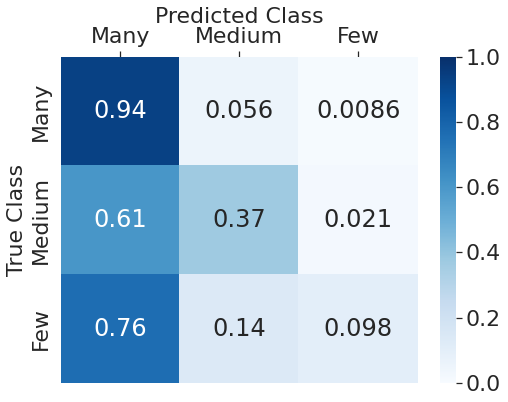

In [20]:
compute_class_acc(cifar100_trainDataset.get_cls_num_list(), pre_res34_targets100, pre_res34_preds100)

#### Vision Transformer

From Scratch

In [21]:
from vit_pytorch import ViT

vit_model100 = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 100,
    dim = 256,
    depth = 3,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)

vit_opt100 = torch.optim.Adam(vit_model100.parameters(), lr=0.07)

vit_accs100, vit_losses100 = basic_train(vit_model100, cifar100_train_loader, vit_opt100, criterion, n_epochs=50)
print("Best Accuracy =", max(vit_accs100))

Epoch 0


100%|██████████| 170/170 [00:09<00:00, 18.67it/s]


Loss = 898.2835054397583
Accuracy = 0.03770627823361298
Epoch 1


100%|██████████| 170/170 [00:08<00:00, 19.06it/s]


Loss = 696.8582227230072
Accuracy = 0.05199594357886973
Epoch 2


100%|██████████| 170/170 [00:08<00:00, 19.13it/s]


Loss = 690.9867799282074
Accuracy = 0.05789619249562091
Epoch 3


100%|██████████| 170/170 [00:08<00:00, 19.19it/s]


Loss = 692.1811439990997
Accuracy = 0.06020097722872684
Epoch 4


100%|██████████| 170/170 [00:08<00:00, 19.14it/s]


Loss = 685.4091291427612
Accuracy = 0.07061860422236563
Epoch 5


100%|██████████| 170/170 [00:08<00:00, 19.21it/s]


Loss = 686.1047229766846
Accuracy = 0.07043422144371715
Epoch 6


100%|██████████| 170/170 [00:08<00:00, 19.03it/s]


Loss = 692.62988114357
Accuracy = 0.06351986724439937
Epoch 7


100%|██████████| 170/170 [00:09<00:00, 18.24it/s]


Loss = 693.326536655426
Accuracy = 0.06665437448142343
Epoch 8


100%|██████████| 170/170 [00:08<00:00, 18.92it/s]


Loss = 698.5941517353058
Accuracy = 0.06388863280169632
Epoch 9


100%|██████████| 170/170 [00:08<00:00, 18.96it/s]


Loss = 694.3398067951202
Accuracy = 0.06425739835899327
Epoch 10


100%|██████████| 170/170 [00:08<00:00, 18.99it/s]


Loss = 692.0215744972229
Accuracy = 0.06517931225223564
Epoch 11


100%|██████████| 170/170 [00:08<00:00, 19.09it/s]


Loss = 693.2564675807953
Accuracy = 0.06720752281736886
Epoch 12


100%|██████████| 170/170 [00:08<00:00, 19.06it/s]


Loss = 690.6687502861023
Accuracy = 0.06886696782520513
Epoch 13


100%|██████████| 170/170 [00:08<00:00, 19.04it/s]


Loss = 692.1119236946106
Accuracy = 0.06942011616115056
Epoch 14


100%|██████████| 170/170 [00:08<00:00, 19.11it/s]


Loss = 694.1847417354584
Accuracy = 0.07356872868074121
Epoch 15


100%|██████████| 170/170 [00:08<00:00, 19.26it/s]


Loss = 690.2214045524597
Accuracy = 0.0722780492302019
Epoch 16


100%|██████████| 170/170 [00:08<00:00, 19.17it/s]


Loss = 689.7378356456757
Accuracy = 0.06481054669493869
Epoch 17


100%|██████████| 170/170 [00:08<00:00, 19.05it/s]


Loss = 723.9345726966858
Accuracy = 0.04840047939522449
Epoch 18


100%|██████████| 170/170 [00:08<00:00, 19.12it/s]


Loss = 703.7791459560394
Accuracy = 0.05900248916751175
Epoch 19


100%|██████████| 170/170 [00:08<00:00, 18.95it/s]


Loss = 701.1708297729492
Accuracy = 0.05485387664792109
Epoch 20


100%|██████████| 170/170 [00:08<00:00, 19.11it/s]


Loss = 702.3415586948395
Accuracy = 0.057711809716972436
Epoch 21


100%|██████████| 170/170 [00:08<00:00, 19.11it/s]


Loss = 698.2498896121979
Accuracy = 0.060938508343320735
Epoch 22


100%|██████████| 170/170 [00:08<00:00, 19.19it/s]


Loss = 698.8249242305756
Accuracy = 0.06232137918318429
Epoch 23


100%|██████████| 170/170 [00:08<00:00, 18.96it/s]


Loss = 737.2277612686157
Accuracy = 0.046925417166036695
Epoch 24


100%|██████████| 170/170 [00:08<00:00, 19.17it/s]


Loss = 705.7842028141022
Accuracy = 0.05605236470913617
Epoch 25


100%|██████████| 170/170 [00:08<00:00, 19.03it/s]


Loss = 700.8101754188538
Accuracy = 0.05522264220521803
Epoch 26


100%|██████████| 170/170 [00:09<00:00, 18.88it/s]


Loss = 697.818197965622
Accuracy = 0.05817276666359362
Epoch 27


100%|██████████| 170/170 [00:09<00:00, 18.10it/s]


Loss = 692.9155809879303
Accuracy = 0.06250576196183276
Epoch 28


100%|██████████| 170/170 [00:08<00:00, 19.23it/s]


Loss = 691.931631565094
Accuracy = 0.06499492947358716
Epoch 29


100%|██████████| 170/170 [00:08<00:00, 19.15it/s]


Loss = 696.0363273620605
Accuracy = 0.058910297778187515
Epoch 30


100%|██████████| 170/170 [00:08<00:00, 19.07it/s]


Loss = 693.2522358894348
Accuracy = 0.06241357057250853
Epoch 31


100%|██████████| 170/170 [00:08<00:00, 19.13it/s]


Loss = 695.2773370742798
Accuracy = 0.058264958052917856
Epoch 32


100%|██████████| 170/170 [00:08<00:00, 19.09it/s]


Loss = 697.7766959667206
Accuracy = 0.05946344611413294
Epoch 33


100%|██████████| 170/170 [00:08<00:00, 19.07it/s]


Loss = 695.5724239349365
Accuracy = 0.05844934083156633
Epoch 34


100%|██████████| 170/170 [00:08<00:00, 19.22it/s]


Loss = 699.47132563591
Accuracy = 0.060477551396699546
Epoch 35


100%|██████████| 170/170 [00:08<00:00, 19.08it/s]


Loss = 700.0122709274292
Accuracy = 0.06020097722872684
Epoch 36


100%|██████████| 170/170 [00:08<00:00, 18.98it/s]


Loss = 697.0987329483032
Accuracy = 0.06103069973264497
Epoch 37


100%|██████████| 170/170 [00:08<00:00, 18.94it/s]


Loss = 689.8881990909576
Accuracy = 0.06729971420669309
Epoch 38


100%|██████████| 170/170 [00:08<00:00, 19.09it/s]


Loss = 699.2301404476166
Accuracy = 0.06683875726007191
Epoch 39


100%|██████████| 170/170 [00:08<00:00, 18.90it/s]


Loss = 705.4198641777039
Accuracy = 0.057711809716972436
Epoch 40


100%|██████████| 170/170 [00:08<00:00, 19.00it/s]


Loss = 709.6427841186523
Accuracy = 0.05632893887710888
Epoch 41


100%|██████████| 170/170 [00:08<00:00, 19.11it/s]


Loss = 709.8256587982178
Accuracy = 0.05752742693832396
Epoch 42


100%|██████████| 170/170 [00:08<00:00, 19.22it/s]


Loss = 698.75168800354
Accuracy = 0.06066193417534802
Epoch 43


100%|██████████| 170/170 [00:08<00:00, 18.99it/s]


Loss = 699.842545747757
Accuracy = 0.0601087858394026
Epoch 44


100%|██████████| 170/170 [00:08<00:00, 19.14it/s]


Loss = 697.9996178150177
Accuracy = 0.06324329307642666
Epoch 45


100%|██████████| 170/170 [00:08<00:00, 19.10it/s]


Loss = 694.3504357337952
Accuracy = 0.06564026919885682
Epoch 46


100%|██████████| 170/170 [00:09<00:00, 18.38it/s]


Loss = 701.5303859710693
Accuracy = 0.06305891029777819
Epoch 47


100%|██████████| 170/170 [00:09<00:00, 18.69it/s]


Loss = 703.7785868644714
Accuracy = 0.061583848068590394
Epoch 48


100%|██████████| 170/170 [00:08<00:00, 19.13it/s]


Loss = 706.5213432312012
Accuracy = 0.058357149442242094
Epoch 49


100%|██████████| 170/170 [00:08<00:00, 19.08it/s]

Loss = 701.494460105896
Accuracy = 0.06075412556467226
Best Accuracy = 0.07356872868074121


In [22]:
vit_preds100, vit_targets100 = basic_test(vit_model100, cifar100_test_loader, criterion)

100%|██████████| 34/34 [00:00<00:00, 40.44it/s]

Test Loss =  139.94928526878357


Overall Accuracy: 5.584232754575317
Many Accuracy: 6.742857142857144
Medium Accuracy: 0.30303030303030304
Few Accuracy: 0.0


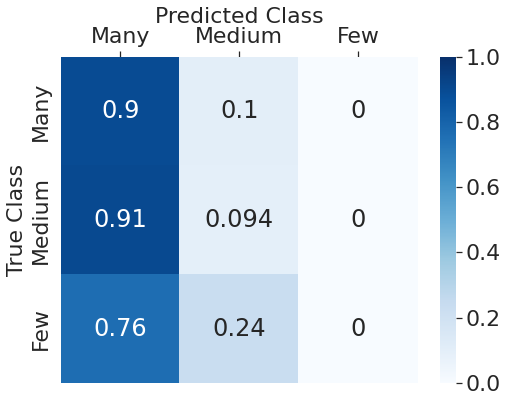

In [23]:
compute_class_acc(cifar100_trainDataset.get_cls_num_list(), vit_targets100, vit_preds100)

Visualize Training of CIFAR-100


In [27]:
sn.set(font_scale=1)

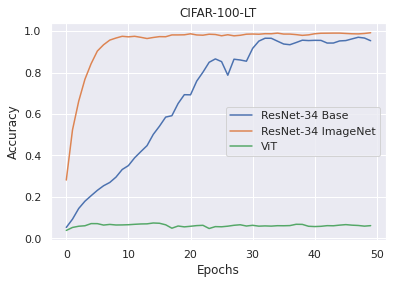

In [28]:
x = list(range(50)) # Number of epochs to plot

plt.plot(x, res34_accs100, label = "ResNet-34 Base")
plt.plot(x, pre_res34_accs100, label = "ResNet-34 ImageNet")
plt.plot(x, vit_accs100, label = "ViT")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CIFAR-100-LT")
plt.legend()
plt.show()

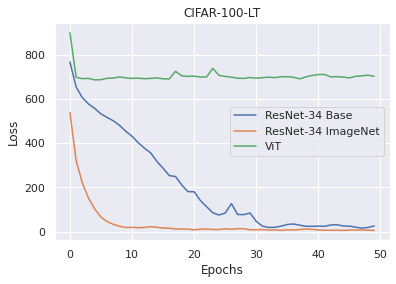

In [29]:
plt.plot(x, res34_losses100, label = "ResNet-34 Base")
plt.plot(x, pre_res34_losses100, label = "ResNet-34 ImageNet")
plt.plot(x, vit_losses100, label = "ViT")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CIFAR-100-LT")
plt.legend()
plt.show()

## BCL Paper Models

In [7]:
from models import resnets
from loss.contrastive import BalSCL
from loss.logitadjust import LogitAdjust
from randaugment import rand_augment_transform
from custom_augments.cutout import Cutout

# ra_params = dict(translate_const=int(224 * 0.45), img_mean=tuple([min(255, round(255 * x)) for x in (0.485, 0.456, 0.406)]), )
normalize = transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
rgb_mean = (0.49139968, 0.48215827 ,0.44653124)  # mean for cifar10
ra_params = dict(translate_const=int(32 * 0.45), img_mean=tuple([min(255, round(255 * x)) for x in rgb_mean]), )

augmentation_randncls = [
        transforms.RandomResizedCrop(32, scale=(0.08, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.0)
        ], p=1.0),
        rand_augment_transform('rand-n{}-m{}-mstd0.5'.format(2, 10), ra_params),
        transforms.ToTensor(),
        transforms.RandomApply([
            Cutout(3, 3),
        ], p=0.5),
        normalize,
    ]

augmentation_randnclsstack = [
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        rand_augment_transform('rand-n{}-m{}-mstd0.5'.format(2, 10), ra_params),
        transforms.ToTensor(),
        transforms.RandomApply([
            Cutout(3, 3),
        ], p=0.5),
        normalize,
    ]

augmentation_sim = [
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ]

transform_train = [transforms.Compose(augmentation_randncls), transforms.Compose(augmentation_randnclsstack), transforms.Compose(augmentation_sim), ]
transform_val = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

alpha = 2.0
beta = 0.6

In [8]:
def adjust_lr(optimizer, lr, epoch, total_epochs):
    """Decay the learning rate based on schedule, simplified to paper default"""
    lr *= 0.5 * (1. + math.cos(math.pi * (epoch + 1) / (total_epochs + 1)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [9]:
def train_BCL(model, train_loader, optimizer, lr, ce_criterion, scl_criterion, cls_num, n_epochs=100):
    model.to(device)
    model.train()

    accs = []
    losses = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_correct = 0
        num_preds = 0

        adjust_lr(optimizer, lr, epoch, n_epochs)

        print("Epoch:", epoch)
        for inputs, targets, mixup_targets in tqdm(train_loader):
            optimizer.zero_grad()
            mixup_targets.squeeze(1)
            # print(mixup_targets)

            inputs = torch.cat([inputs[0], inputs[1], inputs[2]], dim=0)
            inputs, targets, mixup_targets = inputs.to(device), targets.to(device), mixup_targets.to(device)
            batch_size = targets.shape[0]
            feat_mlp, logits, centers = model(inputs)
            centers = centers[:cls_num]
            _, f2, f3 = torch.split(feat_mlp, [batch_size, batch_size, batch_size], dim=0)
            features = torch.cat([f2.unsqueeze(1), f3.unsqueeze(1)], dim=1)
            logits, _, __ = torch.split(logits, [batch_size, batch_size, batch_size], dim=0)
            scl_loss = criterion_scl(centers, features, targets)
            ce_loss = criterion_ce(logits, mixup_targets)
            
            loss = alpha * ce_loss + beta * scl_loss
            loss = ce_loss
            epoch_loss += loss.item()

            epoch_correct += torch.sum(torch.argmax(logits, dim=1) == targets).item()
            num_preds += batch_size

            loss.backward()
            optimizer.step()
      
        epoch_acc = epoch_correct / num_preds
        accs += [epoch_acc]
        losses += [epoch_loss]

        print(f"Loss = {epoch_loss}")
        print(f"Accuracy = {epoch_acc}")

    model.cpu()
    return accs, losses


def validate_BCL(model, val_loader, criterion, cls_num):
    model.to(device)
    model.eval()

    preds = []
    labels = []

    epoch_adj_loss = 0
    epoch_loss = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = targets.size(0)
            feat_mlp, logits, centers = model(inputs)

            targets = torch.nn.functional.one_hot(torch.tensor(targets), cls_num) # If soft-labels
            ce_loss = criterion_ce(logits, targets.float())
            epoch_adj_loss += ce_loss.item()
            loss = criterion(logits, targets.float()) # If soft-labels use targets.float()
            epoch_loss += loss.item()

            preds += torch.argmax(logits, dim=1).view(-1).cpu().detach().tolist()
            # labels += targets.cpu().detach().tolist()

            # Soft-labels
            labels += torch.argmax(targets, dim=1).view(-1).cpu().detach().tolist()

    print("Test Adjusted Classification Loss = ", epoch_adj_loss)
    print("Test Loss = ", epoch_loss)

    model.cpu()
    return preds, labels

CIFAR-10-LT

In [ ]:
bcl_cifar10_train = IMBALANCECIFAR10(root='/DATACENTER/3/zjg/cifar', train=True,
                                 download=True, transform=transform_train, bcl=True, mixup=True)
bcl_cifar10_test = IMBALANCECIFAR10(root='/DATACENTER/3/zjg/cifar', train=False,
                                 download=True, transform=transform_val, bcl=True)

bcl_cifar10_train_loader = DataLoader(bcl_cifar10_train, batch_size=128, shuffle=True, pin_memory=True)
bcl_cifar10_test_loader = DataLoader(bcl_cifar10_test, batch_size=128, shuffle=False, pin_memory=True)

cls_num_list = bcl_cifar10_train.get_cls_num_list()
cls_num = len(cls_num_list)

criterion_ce = LogitAdjust(cls_num_list, 0.65).to(device)
criterion_scl = BalSCL(cls_num_list, 0.1).to(device) # temperature of 0.1

Files already downloaded and verified
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Files already downloaded and verified
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


In [ ]:
bcl_resnet10 = resnets.BCLModel(name='resnet34', num_classes=10, feat_dim=512, use_norm=True)
lr=0.1
bcl10_opt = torch.optim.SGD(bcl_resnet10.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
# bcl10_opt = torch.optim.AdamW(bcl_resnet10.parameters(), lr=0.07, weight_decay=5e-5)

bcl_accs10, bcl_losses10 = train_BCL(bcl_resnet10, bcl_cifar10_train_loader, bcl10_opt, lr, criterion_ce, criterion_scl, cls_num, n_epochs=100)
print("-"*50)
print("Best Accuracy =", max(bcl_accs10))

Epoch: 0


100%|██████████| 97/97 [01:40<00:00,  1.03s/it]


Loss = 270.21300649642944
Accuracy = 0.28155731097855874
Epoch: 1


100%|██████████| 97/97 [01:30<00:00,  1.08it/s]


Loss = 167.81536602973938
Accuracy = 0.31033370949540545
Epoch: 2


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 156.80214166641235
Accuracy = 0.3668386264710624
Epoch: 3


100%|██████████| 97/97 [01:31<00:00,  1.07it/s]


Loss = 152.90617322921753
Accuracy = 0.4158471707238433
Epoch: 4


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 148.38795340061188
Accuracy = 0.42294051265516686
Epoch: 5


100%|██████████| 97/97 [01:32<00:00,  1.04it/s]


Loss = 147.44525969028473
Accuracy = 0.4289053683701435
Epoch: 6


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 145.14223909378052
Accuracy = 0.44010962437530227
Epoch: 7


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 142.00221264362335
Accuracy = 0.4495405448976302
Epoch: 8


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 138.50080597400665
Accuracy = 0.476221183298404
Epoch: 9


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 137.45411086082458
Accuracy = 0.4806545220054812
Epoch: 10


100%|██████████| 97/97 [01:31<00:00,  1.07it/s]


Loss = 135.77229487895966
Accuracy = 0.4850072545542479
Epoch: 11


100%|██████████| 97/97 [01:30<00:00,  1.08it/s]


Loss = 136.93374013900757
Accuracy = 0.47396421086571017
Epoch: 12


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 135.0481789112091
Accuracy = 0.4982266645171691
Epoch: 13


100%|██████████| 97/97 [01:31<00:00,  1.07it/s]


Loss = 135.5413429737091
Accuracy = 0.4820248266967596
Epoch: 14


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 133.0960818529129
Accuracy = 0.4850072545542479
Epoch: 15


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 130.19174098968506
Accuracy = 0.5074157665645656
Epoch: 16


100%|██████████| 97/97 [01:35<00:00,  1.02it/s]


Loss = 129.79179227352142
Accuracy = 0.5165242624536515
Epoch: 17


100%|██████████| 97/97 [01:32<00:00,  1.05it/s]


Loss = 128.37132954597473
Accuracy = 0.5195066903111397
Epoch: 18


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 128.5227246284485
Accuracy = 0.5157182008705465
Epoch: 19


100%|██████████| 97/97 [01:31<00:00,  1.07it/s]


Loss = 127.21812498569489
Accuracy = 0.5177333548283088
Epoch: 20


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 123.74043500423431
Accuracy = 0.5448170240206351
Epoch: 21


100%|██████████| 97/97 [01:31<00:00,  1.07it/s]


Loss = 125.91848850250244
Accuracy = 0.5311945832661615
Epoch: 22


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 124.31687498092651
Accuracy = 0.5349830727067548
Epoch: 23


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 121.58035659790039
Accuracy = 0.5473158149282605
Epoch: 24


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 118.68966221809387
Accuracy = 0.555537643075931
Epoch: 25


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 117.0168040394783
Accuracy = 0.5623085603740126
Epoch: 26


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 121.4478452205658
Accuracy = 0.5482830888279865
Epoch: 27


100%|██████████| 97/97 [01:30<00:00,  1.08it/s]


Loss = 117.76125502586365
Accuracy = 0.5624697726906336
Epoch: 28


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 115.59026157855988
Accuracy = 0.5772206996614542
Epoch: 29


100%|██████████| 97/97 [01:29<00:00,  1.08it/s]


Loss = 115.2165492773056
Accuracy = 0.5694019023053362
Epoch: 30


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 112.38514220714569
Accuracy = 0.5888279864581654
Epoch: 31


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 111.46798330545425
Accuracy = 0.5828631307431887
Epoch: 32


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 109.53377425670624
Accuracy = 0.5950346606480735
Epoch: 33


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 107.55643784999847
Accuracy = 0.6048686119619539
Epoch: 34


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 104.7209398150444
Accuracy = 0.6159116556504917
Epoch: 35


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 105.55438488721848
Accuracy = 0.6077704336611317
Epoch: 36


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 105.91505444049835
Accuracy = 0.6074480090278898
Epoch: 37


100%|██████████| 97/97 [01:31<00:00,  1.05it/s]


Loss = 102.90405374765396
Accuracy = 0.6170401418668386
Epoch: 38


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 101.61002707481384
Accuracy = 0.6213122682572949
Epoch: 39


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 101.61207735538483
Accuracy = 0.6291310656134128
Epoch: 40


100%|██████████| 97/97 [01:31<00:00,  1.07it/s]


Loss = 101.34299629926682
Accuracy = 0.6226019667902628
Epoch: 41


100%|██████████| 97/97 [01:32<00:00,  1.05it/s]


Loss = 100.02188301086426
Accuracy = 0.6283250040303079
Epoch: 42


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 98.60086393356323
Accuracy = 0.6330807673706271
Epoch: 43


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 96.96362632513046
Accuracy = 0.6378365307109464
Epoch: 44


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 94.61373734474182
Accuracy = 0.6512171529904884
Epoch: 45


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 96.04745554924011
Accuracy = 0.6457359342253748
Epoch: 46


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 95.55277854204178
Accuracy = 0.650491697565694
Epoch: 47


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 94.35099476575851
Accuracy = 0.6590359503466064
Epoch: 48


100%|██████████| 97/97 [01:31<00:00,  1.07it/s]


Loss = 94.4735985994339
Accuracy = 0.6565371594389812
Epoch: 49


100%|██████████| 97/97 [01:30<00:00,  1.08it/s]


Loss = 93.14968419075012
Accuracy = 0.657665645655328
Epoch: 50


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 91.8389059305191
Accuracy = 0.6611317104626794
Epoch: 51


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 91.31156140565872
Accuracy = 0.6645171691117201
Epoch: 52


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 89.73138356208801
Accuracy = 0.6767693051749154
Epoch: 53


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 90.95832616090775
Accuracy = 0.6655650491697566
Epoch: 54


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 89.03435283899307
Accuracy = 0.6789456714492987
Epoch: 55


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 87.8107436299324
Accuracy = 0.6769305174915363
Epoch: 56


100%|██████████| 97/97 [01:29<00:00,  1.08it/s]


Loss = 85.90985482931137
Accuracy = 0.6876511365468322
Epoch: 57


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 84.86149835586548
Accuracy = 0.6853941641141383
Epoch: 58


100%|██████████| 97/97 [01:30<00:00,  1.08it/s]


Loss = 85.74885588884354
Accuracy = 0.6870062872803482
Epoch: 59


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 85.05078613758087
Accuracy = 0.6911978075124939
Epoch: 60


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 84.37077277898788
Accuracy = 0.6962759954860551
Epoch: 61


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 82.76878261566162
Accuracy = 0.7076414638078349
Epoch: 62


100%|██████████| 97/97 [01:32<00:00,  1.05it/s]


Loss = 83.87670731544495
Accuracy = 0.6920844752539094
Epoch: 63


100%|██████████| 97/97 [01:30<00:00,  1.08it/s]


Loss = 81.48562902212143
Accuracy = 0.7106238916653232
Epoch: 64


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 80.94176882505417
Accuracy = 0.7160245042721264
Epoch: 65


100%|██████████| 97/97 [01:30<00:00,  1.08it/s]


Loss = 80.39119392633438
Accuracy = 0.7135257133645011
Epoch: 66


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 79.28537064790726
Accuracy = 0.7177172335966467
Epoch: 67


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 79.70979011058807
Accuracy = 0.7182008705465097
Epoch: 68


100%|██████████| 97/97 [01:40<00:00,  1.03s/it]


Loss = 78.62771284580231
Accuracy = 0.7173142028050943
Epoch: 69


100%|██████████| 97/97 [01:33<00:00,  1.04it/s]


Loss = 77.82073378562927
Accuracy = 0.7131226825729485
Epoch: 70


100%|██████████| 97/97 [01:35<00:00,  1.02it/s]


Loss = 76.58269053697586
Accuracy = 0.729163308076737
Epoch: 71


100%|██████████| 97/97 [01:41<00:00,  1.05s/it]


Loss = 76.22566121816635
Accuracy = 0.7325487667257778
Epoch: 72


100%|██████████| 97/97 [01:33<00:00,  1.04it/s]


Loss = 74.85135465860367
Accuracy = 0.7352893761083347
Epoch: 73


100%|██████████| 97/97 [01:31<00:00,  1.07it/s]


Loss = 73.11948776245117
Accuracy = 0.745768176688699
Epoch: 74


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 73.97132098674774
Accuracy = 0.7377881670159601
Epoch: 75


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 73.85575747489929
Accuracy = 0.7411736256650008
Epoch: 76


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 69.77511942386627
Accuracy = 0.7574560696437208
Epoch: 77


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 71.96706062555313
Accuracy = 0.754554247944543
Epoch: 78


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 71.19523787498474
Accuracy = 0.7500403030791553
Epoch: 79


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 69.6872416138649
Accuracy = 0.7573754634854103
Epoch: 80


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 68.28442993760109
Accuracy = 0.7631791068837659
Epoch: 81


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 68.41519558429718
Accuracy = 0.762373045300661
Epoch: 82


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 67.00831827521324
Accuracy = 0.7684185071739481
Epoch: 83


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 66.91376003623009
Accuracy = 0.7747057875221667
Epoch: 84


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 66.47527635097504
Accuracy = 0.7716427535063679
Epoch: 85


100%|██████████| 97/97 [01:29<00:00,  1.08it/s]


Loss = 65.89134165644646
Accuracy = 0.7745445752055456
Epoch: 86


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 66.77935135364532
Accuracy = 0.769546993390295
Epoch: 87


100%|██████████| 97/97 [01:30<00:00,  1.08it/s]


Loss = 65.37605357170105
Accuracy = 0.7822021602450427
Epoch: 88


100%|██████████| 97/97 [01:31<00:00,  1.06it/s]


Loss = 65.52140483260155
Accuracy = 0.7793809447041754
Epoch: 89


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 64.38903698325157
Accuracy = 0.7819603417701112
Epoch: 90


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 64.03584295511246
Accuracy = 0.7818797356118008
Epoch: 91


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 61.71469670534134
Accuracy = 0.7974367241657263
Epoch: 92


100%|██████████| 97/97 [01:29<00:00,  1.08it/s]


Loss = 63.87058672308922
Accuracy = 0.7859100435273255
Epoch: 93


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 61.546852827072144
Accuracy = 0.7969530872158633
Epoch: 94


100%|██████████| 97/97 [01:30<00:00,  1.07it/s]


Loss = 61.83190205693245
Accuracy = 0.7946961147831695
Epoch: 95


100%|██████████| 97/97 [01:29<00:00,  1.08it/s]


Loss = 61.32466918230057
Accuracy = 0.7946961147831695
Epoch: 96


100%|██████████| 97/97 [01:30<00:00,  1.08it/s]


Loss = 60.02830222249031
Accuracy = 0.7944542963082379
Epoch: 97


100%|██████████| 97/97 [01:29<00:00,  1.09it/s]


Loss = 61.47785344719887
Accuracy = 0.7977591487989683
Epoch: 98


100%|██████████| 97/97 [01:30<00:00,  1.08it/s]


Loss = 61.46156433224678
Accuracy = 0.7938900532000644
Epoch: 99


100%|██████████| 97/97 [01:29<00:00,  1.09it/s]

Loss = 61.711959421634674
Accuracy = 0.7914718684507497
--------------------------------------------------
Best Accuracy = 0.7977591487989683


In [ ]:
bcl_res_preds, bcl_res_targets = validate_BCL(bcl_resnet10, bcl_cifar10_test_loader, criterion=nn.CrossEntropyLoss(), cls_num=10)

<ipython-input-8-e346307c19d4>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.nn.functional.one_hot(torch.tensor(targets), cls_num) # If soft-labels


Test Adjusted Classification Loss =  7.621582053601742
Test Loss =  12.60836386680603


Visualize Training of CIFAR-10

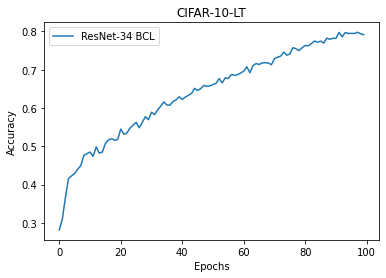

In [ ]:
x = list(range(100)) # Number of epochs to plot

plt.plot(x, bcl_accs10, label = "ResNet-34 BCL")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CIFAR-10-LT")
plt.legend()
plt.show()

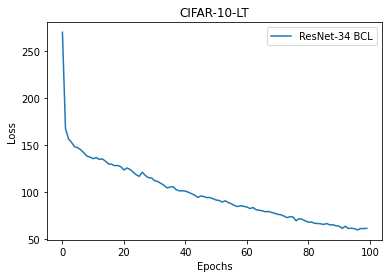

In [ ]:
x = list(range(100)) # Number of epochs to plot

plt.plot(x, bcl_losses10, label = "ResNet-34 BCL")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CIFAR-10-LT")
plt.legend()
plt.show()

Test Results

Test Accuracy =  0.8712671509281679


Text(31.5, 0.5, 'True Class')

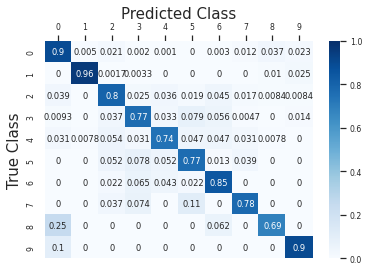

In [ ]:
print("Test Accuracy = ", accuracy_score(bcl_res_targets, bcl_res_preds))
bcl_res_cm = confusion_matrix(bcl_res_targets, bcl_res_preds, normalize='true')
bcl_res_df_cm = pd.DataFrame(bcl_res_cm, index = list(range(10)), columns=list(range(10)))
ax = sn.heatmap(bcl_res_df_cm, annot=True, cmap="Blues", vmin=0, vmax=1)
sn.set(font_scale=0.7)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set(xlabel="Predicted Class", ylabel="True Class")
plt.xlabel("Predicted Class", fontsize = 15) 
plt.ylabel("True Class", fontsize = 15)

CIFAR-100-LT

In [10]:
bcl_cifar100_train = IMBALANCECIFAR100(root='/DATACENTER/3/zjg/cifar', train=True,
                                 download=True, transform=transform_train, bcl=True, mixup="normal")
bcl_cifar100_test = IMBALANCECIFAR100(root='/DATACENTER/3/zjg/cifar', train=False,
                                 download=True, transform=transform_val, bcl=True)

bcl_cifar100_train_loader = DataLoader(bcl_cifar100_train, batch_size=64, shuffle=True, pin_memory=True)
bcl_cifar100_test_loader = DataLoader(bcl_cifar100_test, batch_size=64, shuffle=False, pin_memory=True)

cls_num_list = bcl_cifar100_train.get_cls_num_list()
cls_num = len(cls_num_list)

criterion_ce = LogitAdjust(cls_num_list, 0.75).to(device)
criterion_scl = BalSCL(cls_num_list, 0.1).to(device)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
bcl_resnet100 = resnets.BCLModel(name='resnext50', num_classes=100, feat_dim=512, use_norm=True)
lr=0.1
bcl100_opt = torch.optim.SGD(bcl_resnet100.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

bcl_accs100, bcl_losses100 = train_BCL(bcl_resnet100, bcl_cifar100_train_loader, bcl100_opt, lr, criterion_ce, criterion_scl, cls_num, n_epochs=50)
print("-"*50)
print("Best Accuracy =", max(bcl_accs100))

Epoch: 0


100%|██████████| 170/170 [03:05<00:00,  1.09s/it]


Loss = 999.7170040607452
Accuracy = 0.01115515810823269
Epoch: 1


100%|██████████| 170/170 [03:03<00:00,  1.08s/it]


Loss = 731.077654838562
Accuracy = 0.020927445376601825
Epoch: 2


100%|██████████| 170/170 [03:03<00:00,  1.08s/it]


Loss = 705.490969657898
Accuracy = 0.030884115423619435
Epoch: 3


100%|██████████| 170/170 [03:03<00:00,  1.08s/it]


Loss = 691.5909142494202
Accuracy = 0.04581912049414585
Epoch: 4


100%|██████████| 170/170 [03:03<00:00,  1.08s/it]


Loss = 683.1952519416809
Accuracy = 0.048677053563197195
Epoch: 5


100%|██████████| 170/170 [03:03<00:00,  1.08s/it]


Loss = 675.3998425006866
Accuracy = 0.057343044159675484
Epoch: 6


100%|██████████| 170/170 [03:03<00:00,  1.08s/it]


Loss = 670.7945230007172
Accuracy = 0.06287452751912971
Epoch: 7


100%|██████████| 170/170 [03:03<00:00,  1.08s/it]


Loss = 665.343193769455
Accuracy = 0.06951230755047479
Epoch: 8


100%|██████████| 170/170 [03:02<00:00,  1.08s/it]


Loss = 654.2502341270447
Accuracy = 0.07568913063519868
Epoch: 9


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 650.4736034870148
Accuracy = 0.08435512123167696
Epoch: 10


100%|██████████| 170/170 [03:02<00:00,  1.08s/it]


Loss = 643.9465568065643
Accuracy = 0.08536922651424357
Epoch: 11


100%|██████████| 170/170 [03:02<00:00,  1.08s/it]


Loss = 632.1435515880585
Accuracy = 0.09753848990504287
Epoch: 12


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 629.1613206863403
Accuracy = 0.10454503549368489
Epoch: 13


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 617.7525806427002
Accuracy = 0.11311883470083894
Epoch: 14


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 611.5504758358002
Accuracy = 0.1269475430994745
Epoch: 15


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 600.5408821105957
Accuracy = 0.13570572508527703
Epoch: 16


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 595.3567168712616
Accuracy = 0.1405918687194616
Epoch: 17


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 589.1514849662781
Accuracy = 0.14391075873513415
Epoch: 18


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 577.2302598953247
Accuracy = 0.1577394671337697
Epoch: 19


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 570.9953846931458
Accuracy = 0.16880243385267815
Epoch: 20


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 567.938004732132
Accuracy = 0.1735963860975385
Epoch: 21


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 560.3389699459076
Accuracy = 0.1865031806029317
Epoch: 22


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 550.2039558887482
Accuracy = 0.1939706831381949
Epoch: 23


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 541.3073649406433
Accuracy = 0.20448050152115793
Epoch: 24


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 529.0164709091187
Accuracy = 0.21775606158384808
Epoch: 25


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 524.2886536121368
Accuracy = 0.2347192772195077
Epoch: 26


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 513.5577940940857
Accuracy = 0.24273992809071632
Epoch: 27


100%|██████████| 170/170 [03:01<00:00,  1.07s/it]


Loss = 504.17089891433716
Accuracy = 0.2570295934359731
Epoch: 28


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 499.61191964149475
Accuracy = 0.26560339264312716
Epoch: 29


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 491.58487486839294
Accuracy = 0.2744537660182539
Epoch: 30


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 486.18955636024475
Accuracy = 0.28726836913432285
Epoch: 31


100%|██████████| 170/170 [03:01<00:00,  1.07s/it]


Loss = 475.0219223499298
Accuracy = 0.2967640822347193
Epoch: 32


100%|██████████| 170/170 [03:01<00:00,  1.07s/it]


Loss = 468.546452999115
Accuracy = 0.30506130727390063
Epoch: 33


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 455.61585783958435
Accuracy = 0.32967640822347194
Epoch: 34


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 448.8017256259918
Accuracy = 0.33124366184198395
Epoch: 35


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 440.99782133102417
Accuracy = 0.34682400663778
Epoch: 36


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 428.13411951065063
Accuracy = 0.3671061122891122
Epoch: 37


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 421.3226486444473
Accuracy = 0.38093482068774775
Epoch: 38


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 413.03882908821106
Accuracy = 0.38757260071909283
Epoch: 39


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 401.0017651319504
Accuracy = 0.4100672997142067
Epoch: 40


100%|██████████| 170/170 [03:01<00:00,  1.07s/it]


Loss = 394.50745725631714
Accuracy = 0.41947082142527886
Epoch: 41


100%|██████████| 170/170 [03:01<00:00,  1.07s/it]


Loss = 386.10905504226685
Accuracy = 0.43182446759472665
Epoch: 42


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 375.69456458091736
Accuracy = 0.4474048123905227
Epoch: 43


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 375.1947475671768
Accuracy = 0.4480501521157924
Epoch: 44


100%|██████████| 170/170 [03:01<00:00,  1.07s/it]


Loss = 365.1474840641022
Accuracy = 0.4716511477827971
Epoch: 45


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 361.5935972929001
Accuracy = 0.47404812390522727
Epoch: 46


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 354.29233849048615
Accuracy = 0.49386927260993824
Epoch: 47


100%|██████████| 170/170 [03:01<00:00,  1.07s/it]


Loss = 350.1236960887909
Accuracy = 0.49608186595371995
Epoch: 48


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]


Loss = 345.7822769880295
Accuracy = 0.5043790909929012
Epoch: 49


100%|██████████| 170/170 [03:02<00:00,  1.07s/it]

Loss = 345.36731934547424
Accuracy = 0.5018899234811469
--------------------------------------------------
Best Accuracy = 0.5043790909929012


In [13]:
bcl_res100_preds, bcl_res100_targets = validate_BCL(bcl_resnet100, bcl_cifar100_test_loader, criterion=nn.CrossEntropyLoss(), cls_num=100)

<ipython-input-9-e346307c19d4>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.nn.functional.one_hot(torch.tensor(targets), cls_num) # If soft-labels


Test Adjusted Classification Loss =  51.32084912061691
Test Loss =  63.56237304210663


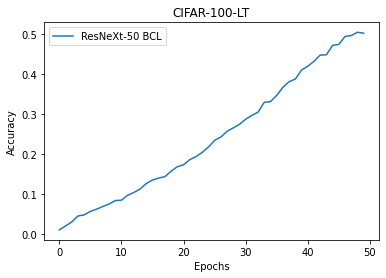

In [15]:
x = list(range(50)) # Number of epochs to plot

plt.plot(x, bcl_accs100, label = "ResNeXt-50 BCL")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CIFAR-100-LT")
plt.legend()
plt.show()

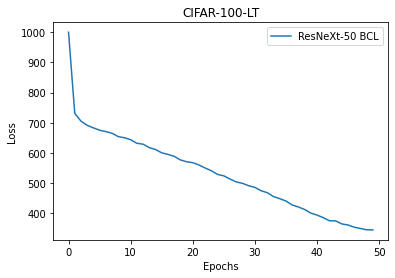

In [16]:
x = list(range(50)) # Number of epochs to plot

plt.plot(x, bcl_losses100, label = "ResNeXt-50 BCL")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CIFAR-100-LT")
plt.legend()
plt.show()

Overall Accuracy: 56.40544345377757
Many Accuracy: 59.542857142857144
Medium Accuracy: 42.72727272727273
Few Accuracy: 37.254901960784316


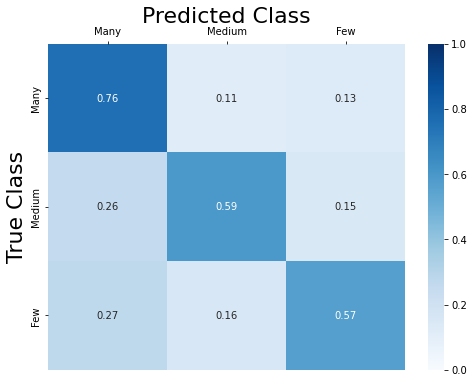

In [17]:
compute_class_acc(cls_num_list, bcl_res100_targets, bcl_res100_preds)

In [ ]:
import pickle as pkl

In [ ]:
pkl.dump({"acc": bcl_accs100, "loss": bcl_losses100, "preds": bcl_res100_preds, "targets": bcl_res100_targets}, open("/content/bcl_100.pkl", 'wb'))

In [ ]:
results = pkl.load(open("/content/bcl_100.pkl", 'rb'))
results['acc']

[0.007928459481884392,
 0.00672997142066931,
 0.010141052825666083,
 0.010325435604314558,
 0.017055407024983867,
 0.02148059371254725,
 0.02009772287268369,
 0.02747303401862266,
 0.026090163178759104,
 0.029593435973080114,
 0.03549368488983129,
 0.031990412095510276,
 0.040011062966718906,
 0.03872038351617959,
 0.043237761593067206,
 0.04452844104360653,
 0.05061307273900618,
 0.05374757997603024,
 0.0643495897483175,
 0.06646999170277496,
 0.07384530284871393,
 0.07762514981100765,
 0.08334101594911035,
 0.08914907347653729,
 0.09504932239328846,
 0.10094957131003965,
 0.10998432746381488,
 0.11837374389232046,
 0.12879137088595924,
 0.1363510648105467,
 0.1495344334839126,
 0.1497188162625611,
 0.16041301742417258,
 0.17368857748686273,
 0.17756061583848068,
 0.18447497003779847,
 0.20180695123075504,
 0.2064165206969669,
 0.2115792384991242,
 0.21720291324790264,
 0.23010970775329584,
 0.23536461694477737,
 0.246888540610307,
 0.25195906702314,
 0.26219231123813036,
 0.270028579